In [21]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from collections import OrderedDict

import os
api_token = os.environ.get('NEPTUNE_API_TOKEN')

plt.style.use('ggplot')

# PARAMETERS

In [8]:
subsampleFreq = 64   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1.
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# UTILITY FUNCTIONS

In [9]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

# LOAD NUMPY ARRAYS

In [10]:
arraySavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/trainTestRTheta.npz'
modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/model1.pth'

npzfile = np.load(arraySavePath)
x_trainRTheta = npzfile['x_trainRTheta']
x_validRTheta = npzfile['x_validRTheta'] 
y_trainRTheta = npzfile['y_trainRTheta'] 
y_validRTheta = npzfile['y_validRTheta']

_,nY = y_validRTheta.shape

In [11]:
batch_size = 64

trainXTensor = torch.Tensor(x_trainRTheta)
trainYTensor = torch.Tensor(y_trainRTheta)

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

validXTensor = torch.Tensor(x_validRTheta)
validYTensor = torch.Tensor(y_validRTheta)

validDataset = TensorDataset(validXTensor,validYTensor)
validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)


print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
print("\ntest: ")
for X, y in validDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train: 
Shape of X [N, C, H, W]: torch.Size([64, 5742])
Shape of y: torch.Size([64, 66]) torch.float32

test: 
Shape of X [N, C, H, W]: torch.Size([64, 5742])
Shape of y: torch.Size([64, 66]) torch.float32


In [33]:
loadFlag = False

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)

class EarlyStopper:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

layerOrderedDict = OrderedDict([('l1', nn.Linear(5742, 512)),
                                ('rl1', nn.ReLU()),
                                ('l2', nn.Linear(512, 512)),
                                ('lr2', nn.ReLU()),
                                ('l3', nn.Linear(512, 66))])

model = NeuralNetwork(layerOrderedDict)
if loadFlag == True:
    model.load_state_dict(torch.load(modelPath))
    
model = model.to(device)
print(model)

Using cuda device
NeuralNetwork(
  (model): Sequential(
    (l1): Linear(in_features=5742, out_features=512, bias=True)
    (rl1): ReLU()
    (l2): Linear(in_features=512, out_features=512, bias=True)
    (lr2): ReLU()
    (l3): Linear(in_features=512, out_features=66, bias=True)
  )
)


In [34]:
epochs = 5000
patience = 50
min_delta = 0

run = neptune.init_run(
    project='jettinger35/predictScalp',
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

loss_fn = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainDataLoader, model, loss_fn, optimizer, t)
    test_loss = test(validDataLoader, model, loss_fn, t)
    
    run["train/loss"].append(train_loss)
    run["test/loss"].append(test_loss)
    
    if early_stopper.early_stop(test_loss):   
        print("Early stopping invoked....")
        break
        
run.stop()
print("Done!")

https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-5
Epoch 1
-------------------------------
loss: 15.806800  [   64/89440]
Test Error: 
 Avg loss: 60.871110 

Epoch 2
-------------------------------
loss: 63.796715  [   64/89440]
Test Error: 
 Avg loss: 15.402270 

Epoch 3
-------------------------------
loss: 19.615705  [   64/89440]
Test Error: 
 Avg loss: 14.557352 

Epoch 4
-------------------------------
loss: 11.506954  [   64/89440]
Test Error: 
 Avg loss: 12.725638 

Epoch 5
-------------------------------
loss: 11.484068  [   64/89440]
Test Error: 
 Avg loss: 10.443370 

Epoch 6
-------------------------------
loss: 9.761872  [   64/89440]
Test Error: 
 Avg loss: 9.366992 

Epoch 7
-------------------------------
loss: 15.559145  [   64/89440]
Test Error: 
 Avg loss: 9.624913 

Epoch 8
-------------------------------
loss: 10.172530  [   64/89440]
Test Error: 
 Avg loss: 9.571256 

Epoch 9
-------------------------------
loss: 10.447509  [   64/89440]
Test Error: 
 Avg

Test Error: 
 Avg loss: 6.003527 

Epoch 79
-------------------------------
loss: 5.760531  [   64/89440]
Test Error: 
 Avg loss: 5.998054 

Epoch 80
-------------------------------
loss: 6.181159  [   64/89440]
Test Error: 
 Avg loss: 6.047323 

Epoch 81
-------------------------------
loss: 5.629356  [   64/89440]
Test Error: 
 Avg loss: 6.176356 

Epoch 82
-------------------------------
loss: 6.617414  [   64/89440]
Test Error: 
 Avg loss: 6.315487 

Epoch 83
-------------------------------
loss: 6.519820  [   64/89440]
Test Error: 
 Avg loss: 6.177620 

Epoch 84
-------------------------------
loss: 4.986633  [   64/89440]
Test Error: 
 Avg loss: 6.082586 

Epoch 85
-------------------------------
loss: 5.049460  [   64/89440]
Test Error: 
 Avg loss: 6.029394 

Epoch 86
-------------------------------
loss: 5.454795  [   64/89440]
Test Error: 
 Avg loss: 6.015696 

Epoch 87
-------------------------------
loss: 6.305834  [   64/89440]
Test Error: 
 Avg loss: 6.017704 

Epoch 88
--

Test Error: 
 Avg loss: 6.177210 

Epoch 156
-------------------------------
loss: 4.822677  [   64/89440]
Test Error: 
 Avg loss: 6.185278 

Epoch 157
-------------------------------
loss: 6.160385  [   64/89440]
Test Error: 
 Avg loss: 6.014114 

Epoch 158
-------------------------------
loss: 10.059049  [   64/89440]
Test Error: 
 Avg loss: 5.824418 

Epoch 159
-------------------------------
loss: 6.004609  [   64/89440]
Test Error: 
 Avg loss: 5.823496 

Epoch 160
-------------------------------
loss: 4.671773  [   64/89440]
Test Error: 
 Avg loss: 5.857225 

Epoch 161
-------------------------------
loss: 6.553252  [   64/89440]
Test Error: 
 Avg loss: 5.841283 

Epoch 162
-------------------------------
loss: 6.325812  [   64/89440]
Test Error: 
 Avg loss: 5.755697 

Epoch 163
-------------------------------
loss: 5.618160  [   64/89440]
Test Error: 
 Avg loss: 5.825346 

Epoch 164
-------------------------------
loss: 6.732742  [   64/89440]
Test Error: 
 Avg loss: 5.782380 

E

Test Error: 
 Avg loss: 5.258760 

Epoch 233
-------------------------------
loss: 3.941875  [   64/89440]
Test Error: 
 Avg loss: 5.325563 

Epoch 234
-------------------------------
loss: 5.948241  [   64/89440]
Test Error: 
 Avg loss: 5.279771 

Epoch 235
-------------------------------
loss: 5.606009  [   64/89440]
Test Error: 
 Avg loss: 5.221290 

Epoch 236
-------------------------------
loss: 6.213875  [   64/89440]
Test Error: 
 Avg loss: 5.263145 

Epoch 237
-------------------------------
loss: 4.602301  [   64/89440]
Test Error: 
 Avg loss: 5.381374 

Epoch 238
-------------------------------
loss: 5.353019  [   64/89440]
Test Error: 
 Avg loss: 5.450160 

Epoch 239
-------------------------------
loss: 5.110857  [   64/89440]
Test Error: 
 Avg loss: 5.445762 

Epoch 240
-------------------------------
loss: 5.481435  [   64/89440]
Test Error: 
 Avg loss: 5.367498 

Epoch 241
-------------------------------
loss: 6.476744  [   64/89440]
Test Error: 
 Avg loss: 5.293889 

Ep

Test Error: 
 Avg loss: 5.160291 

Epoch 310
-------------------------------
loss: 4.953785  [   64/89440]
Test Error: 
 Avg loss: 5.142605 

Epoch 311
-------------------------------
loss: 7.284398  [   64/89440]
Test Error: 
 Avg loss: 5.094143 

Epoch 312
-------------------------------
loss: 4.850763  [   64/89440]
Test Error: 
 Avg loss: 5.187466 

Epoch 313
-------------------------------
loss: 6.433362  [   64/89440]
Test Error: 
 Avg loss: 5.156094 

Epoch 314
-------------------------------
loss: 4.601905  [   64/89440]
Test Error: 
 Avg loss: 5.222412 

Epoch 315
-------------------------------
loss: 5.729912  [   64/89440]
Test Error: 
 Avg loss: 5.096766 

Epoch 316
-------------------------------
loss: 5.046808  [   64/89440]
Test Error: 
 Avg loss: 5.049063 

Epoch 317
-------------------------------
loss: 4.390173  [   64/89440]
Test Error: 
 Avg loss: 5.078509 

Epoch 318
-------------------------------
loss: 4.395928  [   64/89440]
Test Error: 
 Avg loss: 5.126135 

Ep

Test Error: 
 Avg loss: 4.935020 

Epoch 387
-------------------------------
loss: 4.690055  [   64/89440]
Test Error: 
 Avg loss: 5.172356 

Epoch 388
-------------------------------
loss: 3.951761  [   64/89440]
Test Error: 
 Avg loss: 5.701293 

Epoch 389
-------------------------------
loss: 4.985776  [   64/89440]
Test Error: 
 Avg loss: 5.863859 

Epoch 390
-------------------------------
loss: 6.269649  [   64/89440]
Test Error: 
 Avg loss: 5.429063 

Epoch 391
-------------------------------
loss: 5.599421  [   64/89440]
Test Error: 
 Avg loss: 5.268852 

Epoch 392
-------------------------------
loss: 4.982049  [   64/89440]
Test Error: 
 Avg loss: 5.256296 

Epoch 393
-------------------------------
loss: 4.956292  [   64/89440]
Test Error: 
 Avg loss: 5.101881 

Epoch 394
-------------------------------
loss: 5.901866  [   64/89440]
Test Error: 
 Avg loss: 4.938537 

Epoch 395
-------------------------------
loss: 4.311997  [   64/89440]
Test Error: 
 Avg loss: 5.052390 

Ep

Test Error: 
 Avg loss: 4.939934 

Epoch 464
-------------------------------
loss: 4.604241  [   64/89440]
Test Error: 
 Avg loss: 4.923504 

Epoch 465
-------------------------------
loss: 4.760028  [   64/89440]
Test Error: 
 Avg loss: 4.895581 

Epoch 466
-------------------------------
loss: 4.420959  [   64/89440]
Test Error: 
 Avg loss: 4.882302 

Epoch 467
-------------------------------
loss: 4.251324  [   64/89440]
Test Error: 
 Avg loss: 4.842084 

Epoch 468
-------------------------------
loss: 4.420400  [   64/89440]
Test Error: 
 Avg loss: 4.881162 

Epoch 469
-------------------------------
loss: 4.358825  [   64/89440]
Test Error: 
 Avg loss: 4.914090 

Epoch 470
-------------------------------
loss: 5.017644  [   64/89440]
Test Error: 
 Avg loss: 4.917739 

Epoch 471
-------------------------------
loss: 4.608839  [   64/89440]
Test Error: 
 Avg loss: 4.951096 

Epoch 472
-------------------------------
loss: 4.906074  [   64/89440]
Test Error: 
 Avg loss: 4.866395 

Ep

Test Error: 
 Avg loss: 4.978240 

Epoch 541
-------------------------------
loss: 4.830705  [   64/89440]
Test Error: 
 Avg loss: 4.754761 

Epoch 542
-------------------------------
loss: 4.190346  [   64/89440]
Test Error: 
 Avg loss: 4.766478 

Epoch 543
-------------------------------
loss: 4.559215  [   64/89440]
Test Error: 
 Avg loss: 4.890795 

Epoch 544
-------------------------------
loss: 4.474608  [   64/89440]
Test Error: 
 Avg loss: 4.859149 

Epoch 545
-------------------------------
loss: 6.224055  [   64/89440]
Test Error: 
 Avg loss: 4.826304 

Epoch 546
-------------------------------
loss: 5.045824  [   64/89440]
Test Error: 
 Avg loss: 4.752441 

Epoch 547
-------------------------------
loss: 4.506358  [   64/89440]
Test Error: 
 Avg loss: 4.872206 

Epoch 548
-------------------------------
loss: 4.005597  [   64/89440]
Test Error: 
 Avg loss: 4.901514 

Epoch 549
-------------------------------
loss: 4.304173  [   64/89440]
Test Error: 
 Avg loss: 4.701874 

Ep

In [18]:
torch.save(model.state_dict(), modelPath)

# Plot results of fit

<IPython.core.display.Javascript object>


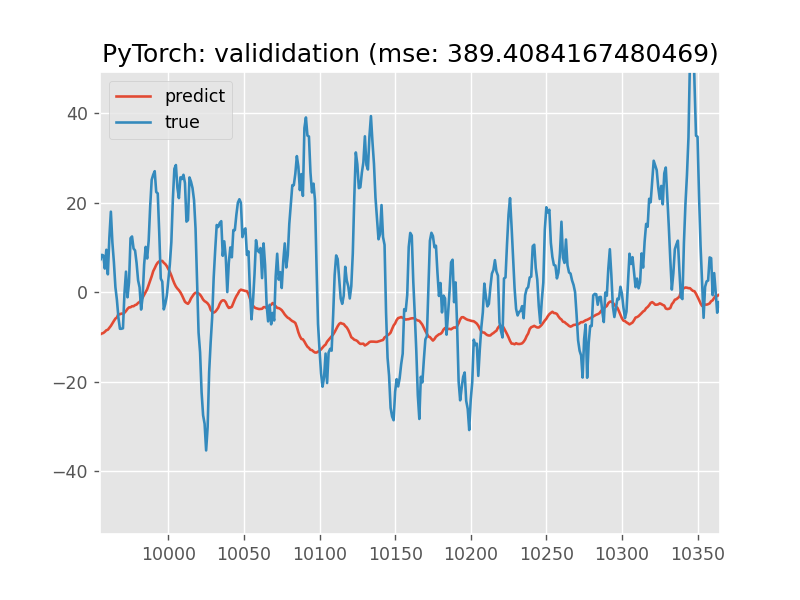

In [30]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = False
    
if trainPlotFlag:
    x = trainXTensor
    y = y_trainRTheta
    trainTitle = 'train'
else:
    x = validXTensor
    y = y_validRTheta
    trainTitle = 'valididation'
    

x = validXTensor.to(device)
freqPredict = model(x).cpu().detach().numpy()

_, yPred = realSTFTtoTimeSeries(freqPredict)
_, yTrue = realSTFTtoTimeSeries(y)

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'PyTorch: ' + trainTitle + ' (mse: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

# SCRATCH BELOW

In [6]:
import neptune

# Create a Neptune run object
run = neptune.init_run(
    project='jettinger35/test',
    api_token=api_token,  
)

# Track metadata and hyperparameters by assigning them to the run
run["JIRA"] = "NPT-952"
run["algorithm"] = "ConvNet"

PARAMS = {
    "batch_size": 64,
    "dropout": 0.2,
    "learning_rate": 0.001,
    "optimizer": "Adam",
}
run["parameters"] = PARAMS

# Track the training process by logging your training metrics
for epoch in range(10):
    run["train/accuracy"].append(epoch * 0.6)  
    run["train/loss"].append(epoch * 0.4)

# Record the final results
run["f1_score"] = 0.66

# Stop the connection and synchronize the data with the Neptune servers
run.stop()


https://new-ui.neptune.ai/jettinger35/test/e/TES-1
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.
All 27 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/jettinger35/test/e/TES-1/metadata
